In [20]:
%pip install catboost

Using Colab cache for faster access to the 'ssh-anomaly-dataset' dataset.
Using Colab cache for faster access to the 'cowrie-medium-interaction' dataset.
--- Training Model ---
0:	learn: 0.4367753	test: 0.4364356	best: 0.4364356 (0)	total: 29.7ms	remaining: 14.8s
100:	learn: 0.0003561	test: 0.0002755	best: 0.0002755 (100)	total: 2.13s	remaining: 8.43s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.000258376502
bestIteration = 112

Shrink model to first 113 iterations.
Accuracy: 1.0000

Testing Raw Model on Cowrie Dataset
Loaded 416519 logs from Cowrie.
Filtered to 62252 login events.


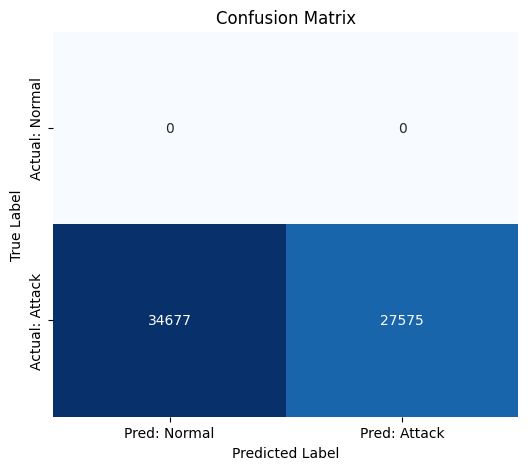


Top Confidence Attacks
                              timestamp           src_ip username  confidence
185597 2023-03-26 03:20:38.140233+00:00  104.248.204.184   ubuntu        74.4
336098 2023-03-31 05:43:51.748018+00:00    68.183.92.232   ubuntu        74.4
185622 2023-03-26 03:21:19.152122+00:00   178.128.21.211     test        74.4
185644 2023-03-26 03:21:23.647900+00:00   178.128.21.211     test        74.4
27861  2023-03-20 05:53:05.824179+00:00    45.81.243.193   ubuntu        74.4
336129 2023-03-31 05:49:08.044114+00:00    68.183.92.232     test        74.4
275289 2023-03-29 05:46:08.785714+00:00  113.253.196.143   ubuntu        74.4
185712 2023-03-26 03:23:11.528134+00:00    164.77.119.34     test        74.4
185729 2023-03-26 03:23:16.683825+00:00    164.77.119.34     test        74.4
27708  2023-03-20 05:49:33.340016+00:00    45.81.243.193     test        74.4

----------------------------------------
Total analyzed: 62252
Attacks detected: 27575 (44.3%)



In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import kagglehub

path = kagglehub.dataset_download("mdwiraputradananjaya/ssh-anomaly-dataset")
path_cowrie = kagglehub.dataset_download("xmlyna/cowrie-medium-interaction")

DATASET_PATH = path + "/ssh_anomaly_dataset.csv"
COWRIE_JSON_PATH = path_cowrie + "/cowrie.json"
TARGET_COLUMN = 'label'


def load_and_prep_data(path):
    df = pd.read_csv(path)

    df = df.drop(columns=['timestamp'])

    df[TARGET_COLUMN] = df[TARGET_COLUMN].apply(lambda x: 0 if str(x).lower() == 'normal' else 1)

    df = df.dropna(axis=1, how='all')
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna('unknown')
        else:
            df[col] = df[col].fillna(0)

    X = df.drop(columns=[TARGET_COLUMN])
    y = df[TARGET_COLUMN]

    categorical_features_indices = np.where(X.dtypes == object)[0]

    return X, y, categorical_features_indices


def train_raw_model():
    print("--- Training Model ---")
    X, y, cat_features = load_and_prep_data(DATASET_PATH)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    model = CatBoostClassifier(
        iterations=500,
        learning_rate=0.1,
        depth=6,
        loss_function='Logloss',
        verbose=100,
        random_seed=42,
        allow_writing_files=False
    )

    model.fit(
        X_train, y_train,
        cat_features=cat_features,
        eval_set=(X_test, y_test),
        early_stopping_rounds=50
    )

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")

    return model, X.columns


def test_raw_model_on_cowrie(model, train_columns, json_path):
    print("\n" + "="*40)
    print("Testing Raw Model on Cowrie Dataset")
    print("="*40)

    df_cowrie = pd.read_json(json_path, lines=True)
    print(f"Loaded {len(df_cowrie)} logs from Cowrie.")

    df_cowrie = df_cowrie[df_cowrie['eventid'].str.contains('cowrie.login', na=False)].copy()
    print(f"Filtered to {len(df_cowrie)} login events.")

    df_test = pd.DataFrame()

    df_test['source_ip'] = df_cowrie['src_ip']
    df_test['username'] = df_cowrie['username'].fillna('unknown')
    df_test['event_type'] = df_cowrie['eventid']
    df_test['status'] = df_cowrie['eventid'].apply(lambda x: 'failed' if 'failed' in str(x) else 'success')
    if 'message' in df_cowrie.columns:
        df_test['detail'] = df_cowrie['message'].fillna('unknown')
    else:
        df_test['detail'] = 'unknown'

    df_meta = df_cowrie[['timestamp', 'src_ip', 'username', 'eventid']].copy()

    for col in train_columns:
        if col not in df_test.columns:
            df_test[col] = 'unknown'

    X_cowrie = df_test[train_columns]

    for col in X_cowrie.columns:
        X_cowrie[col] = X_cowrie[col].astype(str)

    y_pred = model.predict(X_cowrie)
    y_prob = model.predict_proba(X_cowrie)[:, 1]

    # If all data is attack
    y_true = np.ones(len(y_pred))

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred: Normal', 'Pred: Attack'],
                yticklabels=['Actual: Normal', 'Actual: Attack'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    results = df_meta.copy()
    results['decision'] = ['ATAK' if p == 1 else 'Normal' for p in y_pred]
    results['confidence'] = (y_prob * 100).round(1)

    print("\nTop Confidence Attacks")
    attacks = results[results['decision'] == 'ATAK'].sort_values('confidence', ascending=False)

    if not attacks.empty:
        print(attacks[['timestamp', 'src_ip', 'username', 'confidence']].head(10).to_string())

    total_attacks = sum(y_pred)
    print("\n" + "-"*40)
    print(f"Total analyzed: {len(results)}")
    print(f"Attacks detected: {total_attacks} ({(total_attacks/len(results)*100):.1f}%)")
    print("-"*-40)

raw_model, train_cols = train_raw_model()
test_raw_model_on_cowrie(raw_model, train_cols, COWRIE_JSON_PATH)

Model Training
0:	learn: 0.3245243	test: 0.3246613	best: 0.3246613 (0)	total: 14.1ms	remaining: 7.03s
100:	learn: 0.0007004	test: 0.0013877	best: 0.0013877 (100)	total: 1.33s	remaining: 5.27s
200:	learn: 0.0006998	test: 0.0013871	best: 0.0013871 (175)	total: 2.66s	remaining: 3.96s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.001387110213
bestIteration = 175

Shrink model to first 176 iterations.
Accuracy: 0.9999

Precision, Recall, F1-Score
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       741
           1       1.00      1.00      1.00      7624

    accuracy                           1.00      8365
   macro avg       1.00      1.00      1.00      8365
weighted avg       1.00      1.00      1.00      8365


Confusion Matrix


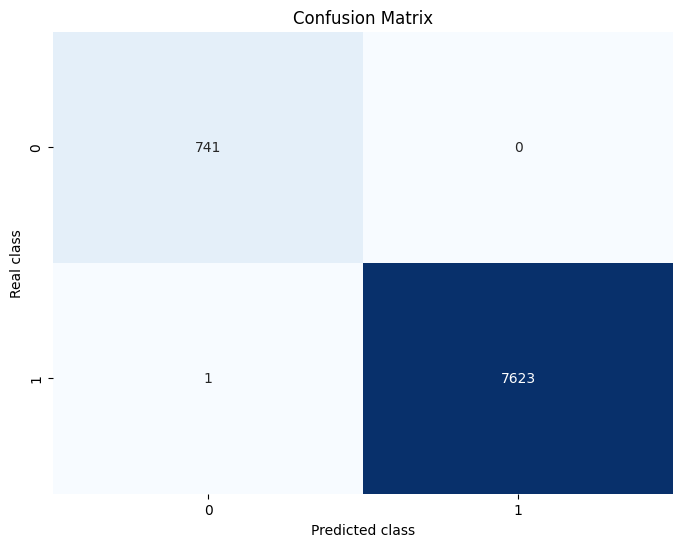


ROC Curve


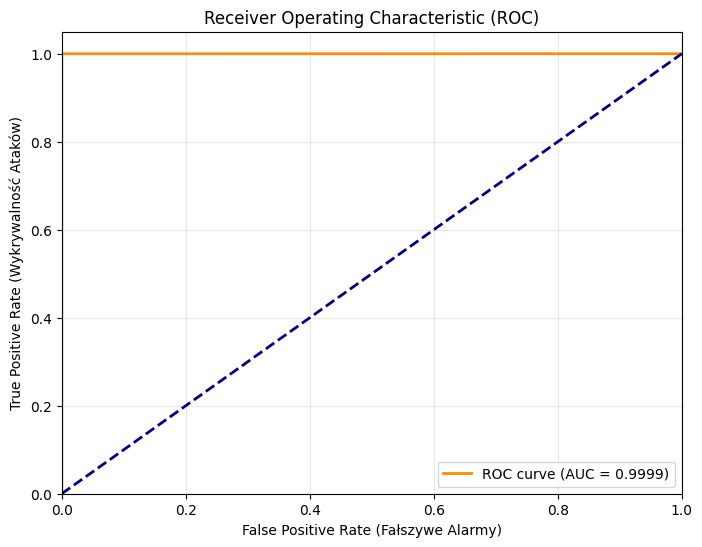


Most important features:
            feature  importance
2   global_ip_count   49.384547
1  rolling_time_avg   33.186868
0  rolling_failures   17.428585


Testing on cowire
Loaded 416519 logs
Found 62252 logging attempts


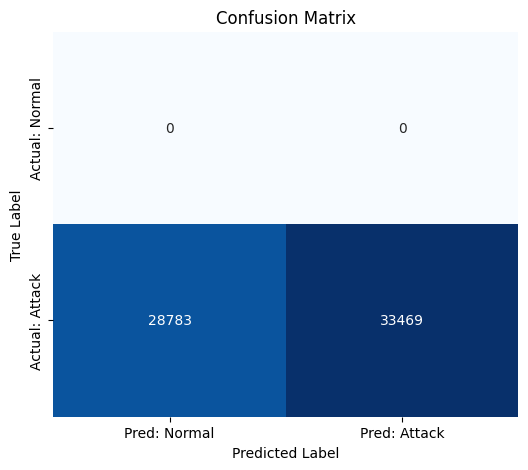


Top Confidence
                              timestamp       source_ip username  rolling_failures  confidence
176522 2023-03-25 20:39:08.770318+00:00  159.89.169.173   tomcat              25.0        99.9
174846 2023-03-25 19:49:13.523808+00:00  159.89.169.173     tidb              26.0        99.9
174851 2023-03-25 19:54:12.839649+00:00  159.89.169.173     tidb              26.0        99.9
174868 2023-03-25 19:59:13.842032+00:00  159.89.169.173     tidb              26.0        99.9
174873 2023-03-25 20:04:12.902417+00:00  159.89.169.173     tidb              26.0        99.9
174893 2023-03-25 20:09:09.434354+00:00  159.89.169.173   tomcat              25.0        99.9
175022 2023-03-25 20:14:08.730634+00:00  159.89.169.173   tomcat              25.0        99.9
174708 2023-03-25 18:24:11.450683+00:00  159.89.169.173    test1              23.0        99.9
174713 2023-03-25 18:29:11.935428+00:00  159.89.169.173    test1              23.0        99.9
174718 2023-03-25 18:34:14.639173+

In [21]:
TRAIN_DATASET_PATH = path + "/ssh_anomaly_dataset.csv"
TEST_COWRIE_JSON = "/kaggle/input/cowrie-medium-interaction/cowrie.json"
TARGET_COLUMN = 'label'

def extract_features_sliding_window(df):
    WINDOW_SIZE = 26

    df_feat = df.copy()

    if 'timestamp' in df_feat.columns:
        df_feat['timestamp'] = pd.to_datetime(df_feat['timestamp'], errors='coerce')
        df_feat = df_feat.sort_values('timestamp')

    if 'status' in df_feat.columns:
        df_feat['is_failed'] = df_feat['status'].astype(str).apply(
            lambda x: 1 if 'fail' in x.lower() or 'error' in x.lower() else 0
        )
    else:
        df_feat['is_failed'] = 0


    grouper = df_feat.groupby('source_ip')

    # Feture 1: Sum of errors in partition
    df_feat['rolling_failures'] = grouper['is_failed'].transform(
        lambda x: x.rolling(window=WINDOW_SIZE, min_periods=1).sum()
    )

    # Feature 2: Average time between logs
    if 'timestamp' in df_feat.columns:
        df_feat['time_diff'] = grouper['timestamp'].diff().dt.total_seconds().fillna(0)
        df_feat['rolling_time_avg'] = grouper['time_diff'].transform(
            lambda x: x.rolling(window=WINDOW_SIZE, min_periods=1).mean()
        )
    else:
        df_feat['rolling_time_avg'] = 0

    # Feature 3: Count of attempts
    df_feat['global_ip_count'] = grouper['source_ip'].transform('count')

    cols_to_drop = ['source_ip', 'username', 'timestamp', 'detail', 'event_type', 'status', 'label', 'session', 'time_diff', 'is_failed', 'dummy_ip', 'eventid', 'message', 'sensor', 'src_ip', 'input', 'outfile', 'shasum']

    existing_drops = [c for c in cols_to_drop if c in df_feat.columns]
    X = df_feat.drop(columns=existing_drops)

    X = X.fillna(0)

    return X, df_feat

def train_model():
    print("Model Training")

    df = pd.read_csv(TRAIN_DATASET_PATH)

    df[TARGET_COLUMN] = df[TARGET_COLUMN].apply(lambda x: 0 if str(x).lower() == 'normal' else 1)
    y = df[TARGET_COLUMN]

    X, _ = extract_features_sliding_window(df)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    model = CatBoostClassifier(
        iterations=500, learning_rate=0.1, depth=6,
        loss_function='Logloss', verbose=100, random_seed=42,
        allow_writing_files=False
    )

    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)

    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")

    print("\nPrecision, Recall, F1-Score")
    print(classification_report(y_test, y_pred))

    print("\nConfusion Matrix")
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted class')
    plt.ylabel('Real class')
    plt.show()

    print("\nROC Curve")
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (Fałszywe Alarmy)')
    plt.ylabel('True Positive Rate (Wykrywalność Ataków)')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

    feature_importances = model.get_feature_importance()
    feature_names = X.columns

    fi_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    fi_df = fi_df.sort_values(by='importance', ascending=False).head(10)

    print("\nMost important features:")
    print(fi_df)

    return model

def test_on_cowrie_json(model, json_path):
    print("\n" + "="*40)
    print("\nTesting on cowire")

    df_cowrie = pd.read_json(json_path, lines=True)
    print(f"Loaded {len(df_cowrie)} logs")

    df_logins = df_cowrie[df_cowrie['eventid'].str.contains('cowrie.login', na=False)].copy()

    print(f"Found {len(df_logins)} logging attempts")

    df_prepared = pd.DataFrame()
    df_prepared['timestamp'] = df_logins['timestamp']
    df_prepared['source_ip'] = df_logins['src_ip']
    df_prepared['session'] = df_logins['session']

    df_prepared['username'] = df_logins['username']

    df_prepared['status'] = df_logins['eventid'].apply(lambda x: 'failed' if 'failed' in x else 'success')

    X_cowrie, df_meta = extract_features_sliding_window(df_prepared)

    expected_cols = model.feature_names_
    for col in expected_cols:
        if col not in X_cowrie.columns:
            X_cowrie[col] = 0

    X_cowrie = X_cowrie[expected_cols]

    y_pred = model.predict(X_cowrie)
    y_prob = model.predict_proba(X_cowrie)[:, 1]


    # If all data is attack
    y_true = np.ones(len(y_pred))

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred: Normal', 'Pred: Attack'],
                yticklabels=['Actual: Normal', 'Actual: Attack'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    results = df_meta[['timestamp', 'source_ip', 'username', 'status', 'rolling_failures', 'rolling_time_avg']].copy()

    results['decision'] = ['ATAK' if p==1 else 'Normal' for p in y_pred]
    results['confidence'] = (y_prob * 100).round(1)

    print("\nTop Confidence")
    attacks = results[results['decision'] == 'ATAK'].sort_values('confidence', ascending=False)
    if not attacks.empty:
        print(attacks[['timestamp', 'source_ip', 'username', 'rolling_failures', 'confidence']].head(10).to_string())

    total_attacks = sum(y_pred)
    print("\n" + "="*40)
    print(f"Analized logs: {len(results)}")
    print(f"Attacks detected: {total_attacks} ({(total_attacks/len(results)*100):.1f}%)")
    print("="*40)

model = train_model()
test_on_cowrie_json(model, "/kaggle/input/cowrie-medium-interaction/cowrie.json")